# Summary

This workbook aims to assess the sentiment of a large number of Amazon reviews mostly focussing on electronics articles. It further looks at the sentiment distributions in relation to the respective review ratings as well as the use of specific words for reviews with both positive and negative sentiments for a given sub-set of products, such as Amazon Kindles, Fires or Electronics in general.

# Import Libraries

In [9]:
import pandas as pd
import numpy as np

#import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import cufflinks as cf
import plotly.graph_objs as go
from plotly.plotly import iplot

import re
import string

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [213]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package punkt to /Users/decoded/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/decoded/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/decoded/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [562]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Import and Transform Dataset

In [418]:
data1 = pd.read_csv("Dataset1.csv")
data2 = pd.read_csv("Dataset2.csv")
df = pd.concat([data1, data2], sort=False)

In [419]:
df = df.reset_index()

In [420]:
set(df["primaryCategories"])

{'Animals & Pet Supplies',
 'Electronics',
 'Electronics,Furniture',
 'Electronics,Hardware',
 'Electronics,Media',
 'Health & Beauty',
 'Home & Garden',
 'Office Supplies',
 'Office Supplies,Electronics',
 'Toys & Games,Electronics'}

In [421]:
df.head()

,index,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.dateAdded
0,0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",NaN
1,1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",NaN
2,2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",NaN
3,3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",NaN
4,4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",NaN


In [422]:
reviews = df["reviews.text"]

In [423]:
df.columns.values

array(['index', 'id', 'dateAdded', 'dateUpdated', 'name', 'asins',
       'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys',
       'manufacturer', 'manufacturerNumber', 'reviews.date',
       'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend',
       'reviews.id', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'sourceURLs', 'reviews.dateAdded'],
      dtype=object)

In [424]:
set(df["primaryCategories"])

{'Animals & Pet Supplies',
 'Electronics',
 'Electronics,Furniture',
 'Electronics,Hardware',
 'Electronics,Media',
 'Health & Beauty',
 'Home & Garden',
 'Office Supplies',
 'Office Supplies,Electronics',
 'Toys & Games,Electronics'}

# Clean Dataset

In [425]:
# remove pet products
df = df[df.primaryCategories != "Animals & Pet Supplies"]

In [426]:
stopset = nltk.corpus.stopwords.words('english')
stopset.extend(["n't", "would"])
punct = str.maketrans('','',string.punctuation)

In [427]:
print(stopset)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [428]:
def clean_text(sample_text):
    sample_text = re.sub(r'[,|.]','',sample_text)
    sample_text = re.sub(r'[#|@|-|?|!]',r' ',sample_text)
    sample_text = sample_text.strip(' ')
    sample_text = re.sub('\s+',' ',sample_text)
    sample_text = sample_text.lower()
    sample_text = WordNetLemmatizer().lemmatize(sample_text)
    
    words = word_tokenize(sample_text)
    words = [w for w in words if w not in stopset]
    
    text = [w.translate(punct) for w in words]
    text = ' '.join(words)
    
    words = [word for word in text if word.isalpha()]
    
    return text

### Test Cleaning Function

In [429]:
sample = df["reviews.text"][5]
sample

"Bought a lot of batteries for Christmas and the AmazonBasics Cell have been good. I haven't noticed a difference between the brand name batteries and the Amazon Basic brand. Just a lot easier to purchase and have arrive at the house and have on hand. Will buy again."

In [430]:
clean_text(sample)

'bought lot batteries christmas amazonbasics cell good noticed difference brand name batteries amazon basic brand lot easier purchase arrive house hand buy'

### Apply Cleaning Function

In [431]:
reviews = reviews.apply(lambda x: clean_text(x))

# Sentiment Analysis

### Apply Simple Sentiment Model

In [432]:
sentiments = []
for review in reviews:
    analysis = TextBlob(review)
    sentiments.append(analysis.sentiment.polarity)
    
reviews_df = pd.DataFrame(reviews)
reviews_df['sentiments'] = sentiments

In [433]:
cf.go_offline()

reviews_df['sentiments'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    theme='pearl',
    colorscale='plotly',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

### Add further Information

In [434]:
reviews_df['rating'] = df['reviews.rating']
reviews_df['productName'] = df['name']
reviews_df['category'] = df['primaryCategories']

In [435]:
# simplify product names for easier analysis
reviews_df['easyName'] = 0
reviews_df.loc[reviews_df['productName'].str.contains("Fire")==True, 'easyName'] = 'Fire'
reviews_df.loc[reviews_df['productName'].str.contains("Kindle")==True, 'easyName'] = 'Kindle'
reviews_df.loc[reviews_df['productName'].str.contains("Echo")==True, 'easyName'] = 'Echo'
reviews_df.loc[reviews_df['easyName'] == 0, 'easyName'] = 'Other'

### Assess Sentiment for different Rating Categories

##### Divide Dataset

In [436]:
positiveRatings = reviews_df.loc[reviews_df['rating'] > 3]
neutralRatings = reviews_df.loc[reviews_df['rating'] == 3]
negativeRatings = reviews_df.loc[reviews_df['rating'] < 3]

##### Positive Ratings

In [437]:
cf.go_offline()

positiveRatings['sentiments'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    theme='pearl',
    colorscale='plotly',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

##### Negative Ratings

In [438]:
cf.go_offline()

negativeRatings['sentiments'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    theme='pearl',
    colorscale='plotly',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

### Distribution of Sentiments and Ratings

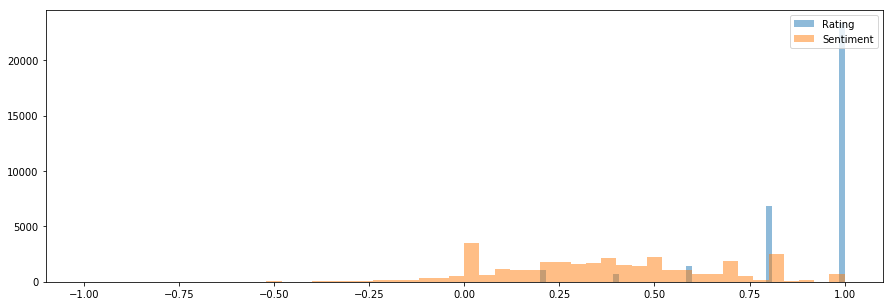

In [698]:
reviews_comp = reviews_df.dropna()
reviews_comp['rating'] = reviews_comp['rating'].apply(lambda x: x/5)

plt.figure(figsize=(15,5))
plt.hist(reviews_comp['rating'], 50, alpha=0.5, label='Rating')
plt.hist(reviews_comp['sentiments'], 50, alpha=0.5, label='Sentiment')
plt.legend(loc='upper right')
plt.show()

### Find most Negative and Positive Reviews

In [439]:
positive = reviews_df.sort_values(by = 'sentiments', ascending=False)
positive = positive.reset_index(drop = True)

negative = reviews_df.sort_values(by = 'sentiments', ascending=True)
negative = negative.reset_index(drop = True)

In [440]:
print(negative)

                                            reviews.text  sentiments  rating  \
0         worst product trash upset serve propose bought       -1.00     1.0   
1      bought batteries 4 - 5 star ratings verified p...       -1.00     1.0   
2                        worst batteries 've ever bought       -1.00     1.0   
3                                               terrible       -1.00     1.0   
4                                   awful batteries work       -1.00     1.0   
5                                        awful batteries       -1.00     1.0   
6      batteries awful might get 1/4 life batteries i...       -1.00     1.0   
7      worst battery ever came across use children 's...       -1.00     1.0   
8      absolutely worst batteries ive ever used amazo...       -1.00     1.0   
9      terrible life poorest quality batteries ever p...       -1.00     5.0   
10                          batteries leak say worst buy       -1.00     1.0   
11                                 terri

### View Individual Reviews

In [682]:
i = 17
print("Review ID {}".format(i),
      "Product Name: {}".format(df['name'][i]),
      "Calculated Sentiment: {}".format(round(reviews_df['sentiments'][i],2)),
      "Review Rating: {}".format(reviews_df['rating'][i]),
      "-----------------------",
      "Original Review: {}".format(df['reviews.text'][i]),
      "-----------------------",
      "Cleaned Review: {}".format(reviews_df['reviews.text'][i]),sep='\n')

Review ID 17
Product Name: AmazonBasics AAA Performance Alkaline Batteries (36 Count)
Calculated Sentiment: -0.04
Review Rating: 2.0
-----------------------
Original Review: In my opinion these did not last anywhere near as long as Duracel in things like LED candles (which is crazy) and trail cameras. Cameras were not exposed to cold temps more or less than other batteries. WE buy in bulk for the north house. Amazon Basics is great for things like sheets and beeding and towels. In my opinion the battery life, in the large package of aaa and aa size we purchased were lacking.
-----------------------
Cleaned Review: opinion last anywhere near long duracel things like led candles ( crazy ) trail cameras cameras exposed cold temps less batteries buy bulk north house amazon basics great things like sheets beeding towels opinion battery life large package aaa aa size purchased lacking


### Add Sentiment Categories

In [447]:
reviews_df['sentiment_category'] = np.where(reviews_df['sentiments']>0, 'Positive',
                                            np.where(reviews_df['sentiments'] == 0, 'Neutral', 'Negative'))

In [448]:
reviews_df.head()

,reviews.text,sentiments,rating,productName,category,easyName,sentiment_category
0,order 3 one item bad quality missing backup sp...,-0.450000,3.0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Other,Negative
1,bulk always less expensive way go products like,-0.333333,4.0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Other,Negative
2,well duracell price happy,0.800000,5.0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Other,Positive
3,seem work well name brand batteries much bette...,0.500000,5.0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Other,Positive
4,batteries long lasting price great,0.250000,5.0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Other,Positive


### Show Wordclounds for Positive and Negative Sentiments

##### Settings

In [632]:
scopeWidget = widgets.Dropdown(options=['category','easyName'],description = 'Scope')
display(scopeWidget)

Dropdown(description='Scope', options=('category', 'easyName'), value='category')

In [651]:
if scopeWidget.value == 'category':
    factorWidget = widgets.Dropdown(options=['Electronics','Electronics,Furniture','Electronics,Hardware',
                                       'Electronics,Media','Health & Beauty','Home & Garden',
                                       'Office Supplies','Office Supplies,Electronics','Toys & Games,Electronics'],
                                        description = 'Factor')
else:
    factorWidget = widgets.Dropdown(options=['Echo','Fire','Kindle','Other'],description = 'Factor')
display(factorWidget)

Dropdown(description='Factor', options=('Electronics', 'Electronics,Furniture', 'Electronics,Hardware', 'Elect…

##### Second Clean

Some of the words below helped assessing sentiment of reviews, however they may be unhelpful to assess WHY the customer wrote the positive or negative review.

In [658]:
unhelpfulWords = ['amazon', 'kindle', 'fire', 'echo', 'tablet', 'good', 'great', 'love', 'disappointed',
                  'bought', 'gift', 'like', 'loves', 'best', 'really', 'one', 'tablets', 'use', 'product']

In [659]:
def second_clean(sample_text):
    words = word_tokenize(sample_text)
    words = [w for w in words if w not in unhelpfulWords]
    
    text = [w.translate(punct) for w in words]
    text = ' '.join(words)
    
    words = [word for word in text if word.isalpha()]
    
    return text

##### Run Analysis

In [660]:
scope = scopeWidget.value
factor = factorWidget.value

In [661]:
# build testset
testset = reviews_df.loc[reviews_df[scope] == factor]
testset['reviews.text'] = testset['reviews.text'].apply(lambda x: second_clean(x))
pos = testset.loc[testset['sentiment_category'] == 'Positive']
neg = testset.loc[testset['sentiment_category'] == 'Negative']

In [662]:
# run analysis for positive
vecPos = TfidfVectorizer(max_features=10000, min_df = 0.01, ngram_range=(1,1))
posBag = vecPos.fit_transform(pos['reviews.text'])

pos_sum_words = posBag.sum(axis=0)
pos_freq = [(word, pos_sum_words[0,idx]) for word, idx in vecPos.vocabulary_.items()]
pos_freq = sorted(pos_freq, key = lambda x: x[1], reverse=True)

if pos_freq[19][1] < 1:
    pos_freq = [(word, pos_sum_words[0,idx]*10) for word, idx in vecPos.vocabulary_.items()]
    pos_freq = sorted(pos_freq, key = lambda x: x[1], reverse=True)

pos_top_words = pos_freq[0:20]

pos_dict = {}
for k, v in pos_top_words:
    pos_dict[k] = int(v)

In [663]:
# run analysis for negative
vecNeg = TfidfVectorizer(max_features=10000, min_df = 0.01, ngram_range=(1,1))
negBag = vecNeg.fit_transform(neg['reviews.text'])

neg_sum_words = negBag.sum(axis=0)
neg_freq = [(word, neg_sum_words[0,idx]) for word, idx in vecNeg.vocabulary_.items()]
neg_freq = sorted(neg_freq, key = lambda x: x[1], reverse=True)

if neg_freq[19][1] < 1:
    neg_freq = [(word, neg_sum_words[0,idx]*10) for word, idx in vecNeg.vocabulary_.items()]
    neg_freq = sorted(neg_freq, key = lambda x: x[1], reverse=True)

neg_top_words = neg_freq[0:20]

neg_dict = {}
for k, v in neg_top_words:
    neg_dict[k] = int(v)

##### Positive WordCloud

<function matplotlib.pyplot.show(*args, **kw)>

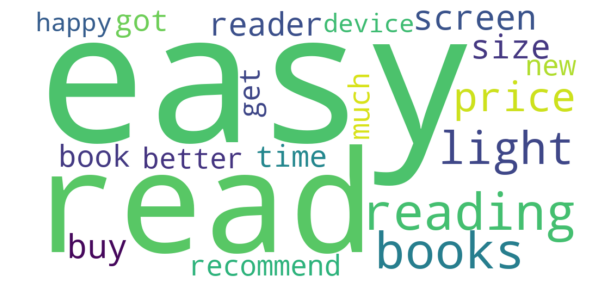

In [664]:
posCloud = WordCloud(width=1000, height=500, background_color = 'white').generate_from_frequencies(pos_dict)

plt.figure(figsize=(10,5))
plt.imshow(posCloud, interpolation='bilinear')
plt.axis('off')
plt.show

##### Negative WordCloud

<function matplotlib.pyplot.show(*args, **kw)>

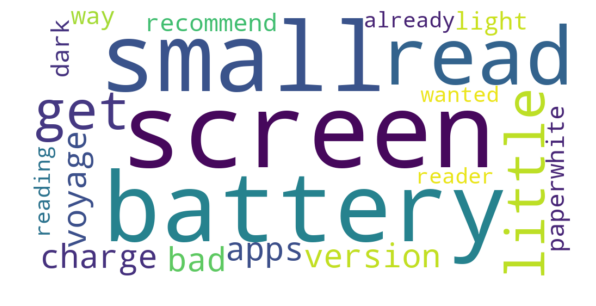

In [650]:
negCloud = WordCloud(width=1000, height=500, background_color = 'white').generate_from_frequencies(neg_dict)

plt.figure(figsize=(10,5))
plt.imshow(negCloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [665]:
factor

'Office Supplies,Electronics'